# Programming assignment 3: Building multilayer perceptron with Tensorflow

## 1. Dataset

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

Using TensorFlow backend.


Reshape dataset for learning problem:

(50000, 28, 28) (50000,)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

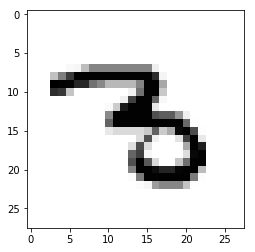

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
plt.imshow(X_train[30], cmap="Greys");

# Features matrix X
num_pixels = 784   # X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_val = X_val.reshape(X_val.shape[0], num_pixels).astype('float32')

# Output vector y
y_train = np.eye(10)[y_train]   # 10
y_test = np.eye(10)[y_test]
y_val = np.eye(10)[y_val]
X_test

The following image illustrates how image pixels are seen as the features in the learning algorithm:

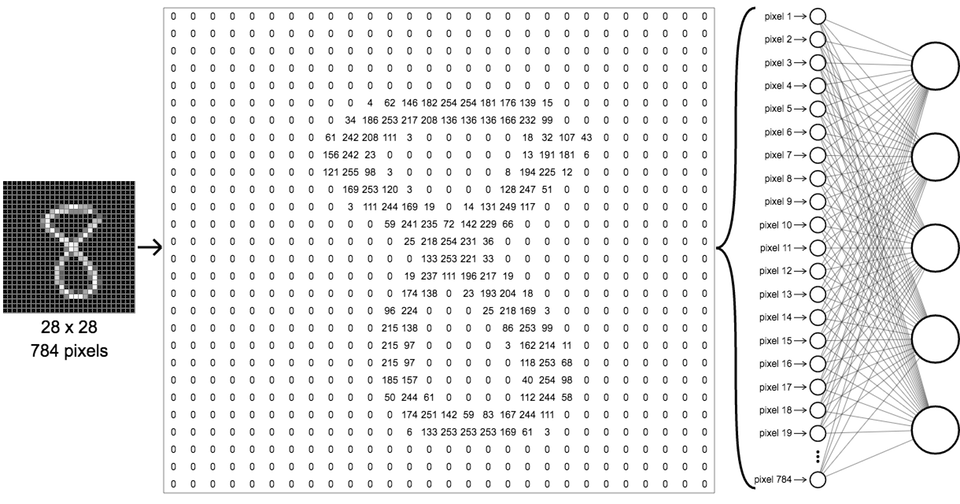

In [3]:
from IPython.display import Image
Image(filename="images/image1.png", height=850, width=850)

## 2. Building a 3-layer neural network model

We wish to implement a deep neural network with 2 hidden layers using the ReLu activation function for capturing nonlinarities, similar to the representation bellow (here with only 1 hidden layer):

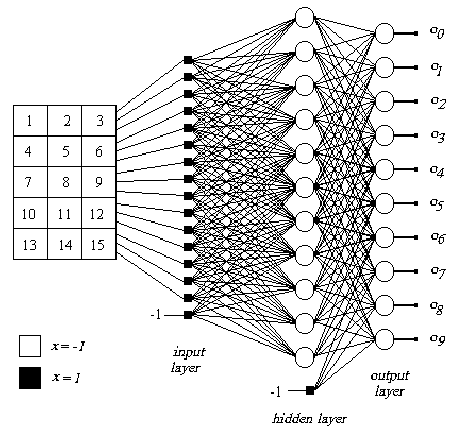

In [4]:
Image(filename="images/image2.png", height=550, width=550)

In [6]:
import tensorflow as tf
tf.reset_default_graph()

### Parameters
#alpha = 0.005 (not needed)
#nu = 0.001 (not needed)
training_epochs = 50
batch_size = 5000
total_batch = 50000

### Layers
hidden_layers_1 = 200
hidden_layers_2 = 200
features = 784        # 28x28 images (flattened here)
n_classes = 10        # Classes: 0-9 handwritten digits

### Model variables
X = tf.placeholder(tf.float32, shape=[None, features])
Y = tf.placeholder(tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(tf.float32)

### Placeholder variables using Xavier weights initilization
W1 = tf.get_variable("W1", [features, hidden_layers_1], initializer=tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable("W2", [hidden_layers_1, hidden_layers_2], initializer=tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable("W3", [hidden_layers_2, n_classes], initializer=tf.contrib.layers.xavier_initializer())

b1 = tf.get_variable("b1", [hidden_layers_1], initializer=tf.zeros_initializer())
b2 = tf.get_variable("b2", [hidden_layers_2], initializer=tf.zeros_initializer())
b3 = tf.get_variable("b3", [n_classes], initializer=tf.zeros_initializer())

### Hidden layer 1
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.relu(Z1)
A1 = tf.nn.dropout(A1, keep_prob)

### Hidden layer 2
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.relu(Z2)
A2 = tf.nn.dropout(A2, keep_prob)

### Output later
Z3 = tf.matmul(A2, W3) + b3
A3 = tf.nn.relu(Z3)

### Cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=A3, labels=Y))

### Loss function using Tikhonov L2 Regularization
#beta = 0.0001
#regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
#cost = tf.reduce_mean(cost + beta * regularizers)

### Decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate_0 = 0.01
alpha = tf.train.exponential_decay(learning_rate_0, global_step, 100000, 0.94, staircase=True)

### Training step
training_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)

## 3. Training a neural network

Start training...

Cost (10 epochs): 0.059384
Accuracy (10 epochs): 0.98214 / 0.9736 / 0.9718

Cost (20 epochs): 0.0252767
Accuracy (20 epochs): 0.99274 / 0.9756 / 0.9776

Cost (30 epochs): 0.0126197
Accuracy (30 epochs): 0.99648 / 0.9786 / 0.979

Cost (40 epochs): 0.00989867
Accuracy (40 epochs): 0.99698 / 0.9768 / 0.9796

Cost (50 epochs): 0.00543673
Accuracy (50 epochs): 0.99886 / 0.9784 / 0.9797

Training completed

Total elapsed time is 396.5385 seconds


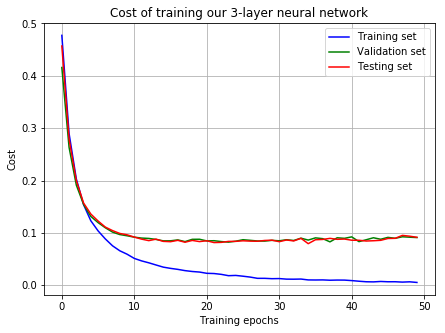

Final train accuracy: 0.99886
Final test accuracy: 0.9797


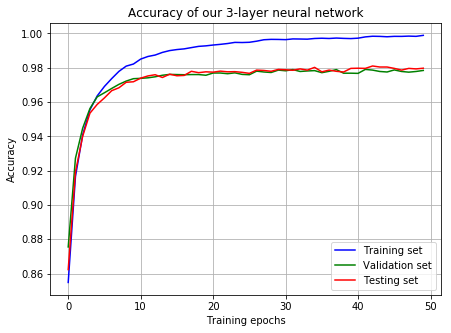

In [7]:
import time

### Initializing the variables
init = tf.global_variables_initializer()

cost_train = []
cost_val = []
cost_test = []

acc_train = []
acc_val = []
acc_test = []


### Running the TensorFlow session
with tf.Session() as sess:
    
    print("Start training...\n")
    start = time.time()
    
    sess.run(init)
    
    for epoch in range(training_epochs):
        
        ### 1. Batch gradient descent
        for i in range(0, total_batch, batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Drop hidden units for regularization of neural network
            sess.run(training_step, feed_dict={X: x_batch, Y: y_batch, keep_prob : 0.65})
        
        ### 2. Learning cost and accuracy using the validation set
        cost_train.append(sess.run(cost, {X: X_train, Y: y_train, keep_prob : 1.0}))
        cost_val.append(sess.run(cost, {X: X_val, Y: y_val, keep_prob : 1.0}))
        cost_test.append(sess.run(cost, {X: X_test, Y: y_test, keep_prob : 1.0}))
        
        predict = tf.argmax(Z3, 1)
        correct_predict = tf.equal(predict, tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_predict, "float"))
        
        ### 3. Evaluate test accuracy at every epoch
        train_accuracy = accuracy.eval({X: X_train, Y: y_train, keep_prob : 1.0})
        val_accuracy = accuracy.eval({X: X_val, Y: y_val, keep_prob : 1.0})
        test_accuracy = accuracy.eval({X: X_test, Y: y_test, keep_prob : 1.0})
        
        acc_train.append(train_accuracy)
        acc_val.append(val_accuracy)
        acc_test.append(test_accuracy)
        
        ### 4. Print progress
        if epoch%10 == 9:
            print("Cost (" + str(epoch+1) + " epochs): " + str(cost_train[-1]))
            print("Accuracy (" + str(epoch+1) + " epochs): " + str(train_accuracy) + " / " + str(val_accuracy) + " / " + str(test_accuracy))
            print("")
        
    print("Training completed\n\nTotal elapsed time is {:.4f} seconds".format(time.time() - start))
    
    ### 5. Cost history of training our neural network
    plt.figure(figsize=(7,5))
    plt.plot(range(len(cost_train)), cost_train, color="blue", lw=1.5, label="Training set")
    plt.plot(range(len(cost_val)), cost_val, color="green", lw=1.5, label="Validation set")
    plt.plot(range(len(cost_test)), cost_test, color="red", lw=1.5, label="Testing set")
    plt.xlabel("Training epochs")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.legend(loc="best")
    plt.title("Cost of training our 3-layer neural network")
    plt.show()

    ### 6. Final accuracy of our neural network
    predict = tf.argmax(Z3, 1)
    correct_predict = tf.equal(predict, tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_predict, "float"))
    print("Final train accuracy:", accuracy.eval({X: X_train, Y: y_train, keep_prob : 1.0}))
    print("Final test accuracy:", accuracy.eval({X: X_test, Y: y_test, keep_prob : 1.0}))
    
    plt.figure(figsize=(7,5))
    plt.plot(range(len(acc_train)), acc_train, color="blue", lw=1.5, label="Training set")
    plt.plot(range(len(acc_val)), acc_val, color="green", lw=1.5, label="Validation set")
    plt.plot(range(len(acc_test)), acc_test, color="red", lw=1.5, label="Testing set")
    plt.xlabel("Training epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend(loc="best")
    plt.title("Accuracy of our 3-layer neural network")
    plt.show()